In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
pd.options.mode.chained_assignment = None

In [2]:
data = pd.read_excel("data/online_retail_II.xlsx")

In [3]:
data.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


## Descriptive Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
data.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [6]:
data.describe(include="O")

,Invoice,StockCode,Description,Country
count,525461,525461,522533,525461
unique,28816,4632,4681,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
freq,675,3516,3549,485852


The analysis of the dataset provides insightful statistics:

- `Quantity`: 
    - The Quantity column includes a minimum value of -9600, which is unusual and requires further investigation to understand whether it represents returns, cancellations, or data errors. 
    - On average, orders contain 10 items, with a maximum single-order quantity of 19,152 items. The high variance in order quantities indicates diverse order sizes across transactions.

- `Order Price`: 
    - The Price column has negative values, with a minimum of -53594.36. This anomaly suggests possible data issues or adjustments, which should be examined in detail to ensure accuracy. 
    - The maximum order price is 25,111, while the average price is 4, suggesting a significant spread in order values. This range implies that some items may have premium prices or involve bulk purchasing.

- `Customer ID`: 
    There are 417,534 non-null values in the Customer ID column, indicating missing data for some entries. This gap needs further examination, especially when grouping data by customer, to avoid skewing results.

- `Missing Descriptions`: 
    The Description field is missing for 2,928 entries, which may impact item-level insights. Addressing these gaps could improve item-specific analysis.

- `Customer Geography`: 
    Customers come from 40 different countries, with the United Kingdom as the leading market, accounting for 485,852 orders.

- `Top-Selling Item`: 
    The most frequently ordered item is the **'WHITE HANGING HEART T-LIGHT HOLDER'**, appearing 3,549 times, suggesting it is highly popular.

### Null Value Analysis 

##### NULL Customer ID

In [7]:
data[data['Customer ID'].isna()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525233,538160,20956,NaN,288,2010-12-09 17:18:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


- A substantial portion of entries with missing Customer ID values also have negative quantity, likely representing returns or adjustments. These entries often have zero prices, indicating they may not represent actual sales transactions.

- Some of these records with null Customer ID values also lack item descriptions, which further complicates analysis and could skew customer-based insights.

Since these records lack sufficient data to assign a Customer ID and could affect segmentation, they should be removed before proceeding with customer grouping.

##### Negative Quantity 

In [8]:
data[data["Quantity"] < 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom
525235,538162,46000M,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


- There are 12,326 records where Quantity is negative, often associated with invoice numbers starting with "C". This prefix likely indicates cancellations or returns, as these records appear to represent adjustments rather than sales.

- Some records with negative quantities also lack a Customer ID, adding to the likelihood that they are cancellations or returns that don’t correspond to a specific customer transaction.

### Analyzing Transactions using Invoice

As mentioned in data description 

*InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.* 

Let's analyze it further.

In [9]:
data['Invoice'] = data['Invoice'].astype('str')

In [10]:
data[data['Invoice'].str.startswith("C")].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia


In [11]:
data[~data['Invoice'].str.match("^\\d{6}$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.0,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.0,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.0,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.0,United Kingdom


This shows the unusual invoice number e.g for transactions like cancellation, adjustment etc. Let's see what else category of transactions this represent other than cancellation(as indicated by C at beginning of Invoice number).

In [12]:
data['Invoice'].str.replace("[0-9]","", regex=True).unique()

array(['', 'C', 'A'], dtype=object)

So, we can conclude that **Cancellations** aren't the only unusual transactions, we can have some transactions with prefix **A**, which we need to further analyze.

In [13]:
data[data['Invoice'].str.startswith("A")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


Analyzing this, we come to the following conclusion:
- There are about **10209** records that shows unusual transactions.
- Majority of them being the order cancellations as indicated by 'C' at the start of Invoice number.
- Only 3 records reresents Accounting adjustment, as indicated by 'A' at the start of Invoice number. It seems like quaterly debt adjusment records. *These will be dropped without any doubt because it won't help us in customer segmentation*.
- The transaction records against cancellation have valid CustomerID and price too, but with negative quantity.

### Analyzing Transactions using StockCodes 

First analysis will be to determine if stock codes are only 5-digit numbers, as mentioned in data description.

*StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.*

In [14]:
data['StockCode'] = data["StockCode"].astype("str")

In [15]:
data[~data["StockCode"].str.match("^\\d{5}$")]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.0,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.0,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.0,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.0,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.0,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.0,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.0,United Kingdom


This shows that **Stock Codes** do have letter at the end of it, which also seems legit as per other fields like Description and Customer ID etc. But we need to examine it further.

In [16]:
data[~(data["StockCode"].str.match("^\\d{5}$")) & ~(data["StockCode"].str.match("^\\d{5}[a-zA-Z]+$"))]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,12682.0,France
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.0,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,12362.0,Belgium
625,489526,POST,POSTAGE,6,2009-12-01 11:50:00,18.00,12533.0,Germany
735,C489535,D,Discount,-1,2009-12-01 12:11:00,9.00,15299.0,United Kingdom
...,...,...,...,...,...,...,...,...
524776,538147,M,Manual,1,2010-12-09 16:11:00,15.00,13090.0,United Kingdom
524887,538148,DOT,DOTCOM POSTAGE,1,2010-12-09 16:26:00,547.32,NaN,United Kingdom
525000,538149,DOT,DOTCOM POSTAGE,1,2010-12-09 16:27:00,620.68,NaN,United Kingdom
525126,538153,DOT,DOTCOM POSTAGE,1,2010-12-09 16:31:00,822.94,NaN,United Kingdom


In [17]:
stockcodes_to_analyze = data[~(data["StockCode"].str.match("^\\d{5}$")) & ~(data["StockCode"].str.match("^\\d{5}[a-zA-Z]+$"))]['StockCode'].unique()
stockcodes_to_analyze

array(['POST', 'D', 'DCGS0058', 'DCGS0068', 'DOT', 'M', 'DCGS0004',
       'DCGS0076', 'C2', 'BANK CHARGES', 'DCGS0003', 'TEST001',
       'gift_0001_80', 'DCGS0072', 'gift_0001_20', 'DCGS0044', 'TEST002',
       'gift_0001_10', 'gift_0001_50', 'DCGS0066N', 'gift_0001_30',
       'PADS', 'ADJUST', 'gift_0001_40', 'gift_0001_60', 'gift_0001_70',
       'gift_0001_90', 'DCGSSGIRL', 'DCGS0006', 'DCGS0016', 'DCGS0027',
       'DCGS0036', 'DCGS0039', 'DCGS0060', 'DCGS0056', 'DCGS0059', 'GIFT',
       'DCGSLBOY', 'm', 'DCGS0053', 'DCGS0062', 'DCGS0037', 'DCGSSBOY',
       'DCGSLGIRL', 'S', 'DCGS0069', 'DCGS0070', 'DCGS0075', 'B',
       'DCGS0041', 'ADJUST2', '47503J ', 'C3', 'SP1002', 'AMAZONFEE'],
      dtype=object)

In [18]:
for code in stockcodes_to_analyze:
    print(f"Code: {code}")
    print(data[data['StockCode'].str.contains(f"^{code}$")][['Invoice', 'Description', 'Price', 'Customer ID']])
    print("\n-----------------------------------\n")

Code: POST
        Invoice Description   Price  Customer ID
89       489439     POSTAGE   18.00      12682.0
126      489444     POSTAGE  141.00      12636.0
173      489447     POSTAGE  130.00      12362.0
625      489526     POSTAGE   18.00      12533.0
927     C489538     POSTAGE    9.58      15796.0
...         ...         ...     ...          ...
522916   537967     POSTAGE   18.00      12494.0
522930   537995     POSTAGE   18.00      12712.0
522974   538003     POSTAGE   18.00      12429.0
523064   538008     POSTAGE   18.00      12683.0
524491   538093     POSTAGE   18.00      12682.0

[865 rows x 4 columns]

-----------------------------------

Code: D
        Invoice Description   Price  Customer ID
735     C489535    Discount    9.00      15299.0
736     C489535    Discount   19.00      15299.0
24675   C491428    Discount    9.10      15494.0
29414   C491845    Discount    1.59          NaN
29958   C491962    Discount    0.59      13206.0
...         ...         ...     ...  

      Invoice             Description  Price  Customer ID
30672  491969  CAT CAMOUFLAGUE COLLAR   5.17          NaN
34669  492303  CAT CAMOUFLAGUE COLLAR   5.17          NaN
41261  492783  CAT CAMOUFLAGUE COLLAR   5.17          NaN

-----------------------------------

Code: gift_0001_20
       Invoice                         Description  Price  Customer ID
32048   491971  Dotcomgiftshop Gift Voucher £20.00  17.39          NaN
40905   492782  Dotcomgiftshop Gift Voucher £20.00  17.39          NaN
45213   493404  Dotcomgiftshop Gift Voucher £20.00  17.39          NaN
75097   496247  Dotcomgiftshop Gift Voucher £20.00  17.02          NaN
96283   498443  Dotcomgiftshop Gift Voucher £20.00  17.02          NaN
153282  503940  Dotcomgiftshop Gift Voucher £20.00  17.02          NaN
181337  506577  Dotcomgiftshop Gift Voucher £20.00  17.02          NaN
195555  508077  Dotcomgiftshop Gift Voucher £20.00  17.02          NaN
254427  513946                                 NaN   0.00          NaN
2

       Invoice      Description  Price  Customer ID
80231   496722              NaN   0.00          NaN
241372  512738           update   0.00          NaN
244831  513099  GIRLS PARTY BAG   3.36          NaN
246184  513200  GIRLS PARTY BAG   3.36          NaN
249938  513574  GIRLS PARTY BAG   3.36          NaN
251930  513655  GIRLS PARTY BAG   3.36          NaN
253997  513907  GIRLS PARTY BAG   3.36          NaN
385192  526405  GIRLS PARTY BAG   3.36          NaN
425616  530060  GIRLS PARTY BAG   3.36          NaN
427107  530140  GIRLS PARTY BAG   3.36          NaN
465555  533338  GIRLS PARTY BAG   3.36          NaN
496963  535835  GIRLS PARTY BAG   3.36          NaN

-----------------------------------

Code: DCGS0006
      Invoice Description  Price  Customer ID
80337  496740         NaN    0.0          NaN

-----------------------------------

Code: DCGS0016
      Invoice Description  Price  Customer ID
80338  496741         NaN    0.0          NaN

---------------------------------

The analysis of **StockCode** values can be concluded as follow:

- We have **80112** records/transactions with stock code that is not valid according to the data description, out of which **3098** represents unusual stock code values.
- StockCode values with *D* or starting with *DCG* are the valid transactions representing discount on orders.
- *m* and *M* StockCodes represent transactions done manually.
- Based on the content in Description field, the StockCode *DOT* shows valid transactions of Postage Charges.
- StockCodes like *B* and *BANK CHARGES* shows transactions against bank charges. Similarly, *AMAZON FEE* StockCode shows amazon.com charges.
- StockCode *S* represent the samples sent out to the customers.
- StockCode containing *TEST* keyword in it shows records entries done for the purpose of testing.
- StockCode containing keyword *gift* shows order purchased using giftcards.
- *SP1002* StockCode shows some random transaction maybe special request order, but we are not sure about it.
- StockCode containing keyword *ADJUST* represent transactions recorded against Accounting adjustments.
- Records with *PADS* as StockCode represent valid transactions based on other fields data.
- StockCode *C2* apparently shows 'Carriage Transactions' (not sure what it actually is) and *C3* shows invalid transaction.

# Data Cleaning 

In [19]:
cleaned_data = data.copy()

In [20]:
cleaned_data['Invoice'] = cleaned_data['Invoice'].astype("str")

In [21]:
mask1 = (~cleaned_data['Customer ID'].isna()) #drop records with null Customer ID

mask2 = (cleaned_data['Quantity']>0) # drop records with negative quantity

mask3 = (cleaned_data['Price']>0) #drop records with negative price.

mask4 = cleaned_data['Invoice'].str.match("^\\d{6}$") # removing invalid invoice based records

mask5 = (
    (cleaned_data["StockCode"].str.match("^\\d{5}$")) |
    (cleaned_data["StockCode"].str.match("^\\d{5}[a-zA-Z]+$")) |
    (cleaned_data["StockCode"].str.match("^PADS$"))

) # removing records with unusual stock-codes

In [22]:
cleaned_data = cleaned_data[mask1 & mask2 & mask3 & mask4 & mask5]
cleaned_data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [23]:
cleaned_data.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,406309.000000,406309,406309.000000,406309.000000
mean,13.617924,2010-07-01 10:14:25.869572352,2.991668,15373.722268
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000
25%,2.000000,2010-03-26 14:01:00,1.250000,14006.000000
50%,5.000000,2010-07-09 15:48:00,1.950000,15326.000000
75%,12.000000,2010-10-14 17:09:00,3.750000,16814.000000
max,19152.000000,2010-12-09 20:01:00,295.000000,18287.000000
std,96.998833,NaN,4.285951,1677.329470


#### Data dropped during cleaning phase

In [24]:
dropped_data_count = len(cleaned_data)/len(data)
print(f"The data that we lost while cleaning phase is {dropped_data_count:.2f}({dropped_data_count*100:.1f}%)")

The data that we lost while cleaning phase is 0.77(77.3%)


During EDA, we analyze various data fields and dig further into anomalous records. In the data cleaning process, the indicated anomalous records are removed to make data as much cleaned as possible for our data clustering step.

# Feature Engineering

In [25]:
cleaned_data["SaleTotal"] = cleaned_data["Price"] * cleaned_data["Quantity"]
cleaned_data.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SaleTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0


In [26]:
agg_data = cleaned_data.groupby("Customer ID", as_index=False).agg(
    MonetaryValue = ("SaleTotal", "sum"),
    Frequency = ("Invoice", "nunique"),
    LastInvoiceDate = ("InvoiceDate", "max")
    
)
agg_data.head(5)

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.0,169.36,2,2010-06-28 13:53:00
1,12347.0,1323.32,2,2010-12-07 14:57:00
2,12348.0,221.16,1,2010-09-27 14:59:00
3,12349.0,2221.14,2,2010-10-28 08:23:00
4,12351.0,300.93,1,2010-11-29 15:23:00


In [27]:
max_invoice_date = agg_data["LastInvoiceDate"].max()

agg_data["Recency"] = (agg_data["LastInvoiceDate"].max() - agg_data["LastInvoiceDate"]).dt.days

In [28]:
agg_data.head()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346.0,169.36,2,2010-06-28 13:53:00,164
1,12347.0,1323.32,2,2010-12-07 14:57:00,2
2,12348.0,221.16,1,2010-09-27 14:59:00,73
3,12349.0,2221.14,2,2010-10-28 08:23:00,42
4,12351.0,300.93,1,2010-11-29 15:23:00,10


### Data Distribution Analysis

In [29]:
agg_data.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,4285.000000,4285.000000,4285.000000,4285,4285.000000
mean,15356.806768,2024.126801,4.426138,2010-09-11 00:06:10.431738624,89.548191
min,12346.000000,1.550000,1.000000,2009-12-01 10:49:00,0.000000
25%,13891.000000,307.560000,1.000000,2010-07-27 14:39:00,17.000000
50%,15362.000000,702.900000,2.000000,2010-10-19 12:10:00,51.000000
75%,16840.000000,1704.290000,5.000000,2010-11-22 11:24:00,135.000000
max,18287.000000,349164.350000,183.000000,2010-12-09 20:01:00,373.000000
std,1699.839258,8813.945538,7.938017,NaN,96.359872


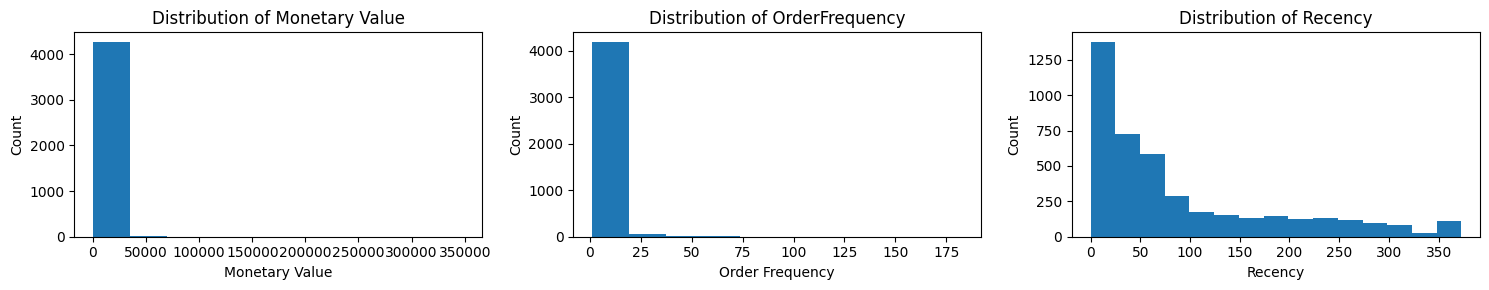

In [30]:
plt.figure(figsize=(15,3))

plt.subplot(1,3,1)
plt.hist(agg_data["MonetaryValue"], bins=10)
plt.title("Distribution of Monetary Value")
plt.xlabel("Monetary Value")
plt.ylabel("Count")

plt.subplot(1,3,2)
plt.hist(agg_data["Frequency"], bins=10)
plt.title("Distribution of OrderFrequency")
plt.xlabel("Order Frequency")
plt.ylabel("Count")

plt.subplot(1,3,3)
plt.hist(agg_data["Recency"], bins=15)
plt.title("Distribution of Recency")
plt.xlabel("Recency")
plt.ylabel("Count")


plt.tight_layout()
plt.show()

**Monetary Value:**

The distribution of monetary value is heavily right-skewed, indicating that while most values are relatively low, there are a few high-value outliers that significantly impact the upper end of the scale. These extreme values requires a closer examination of outliers, as they could reflect high-spending customers or potential data anomalies.


**Order Frequency:**

Order frequency also displays a positively skewed distribution, with a considerable spread. This variation suggests a diverse purchasing pattern across customers, with some making very frequent purchases. Outlier analysis is recommended here to better understand the factors behind these high frequencies.


**Recency:**

The distribution of recency appears more uniform. This indicates a consistent range in the time since the last purchase, with fewer outliers or extreme values impacting the dataset.

#### Outlier Analysis 

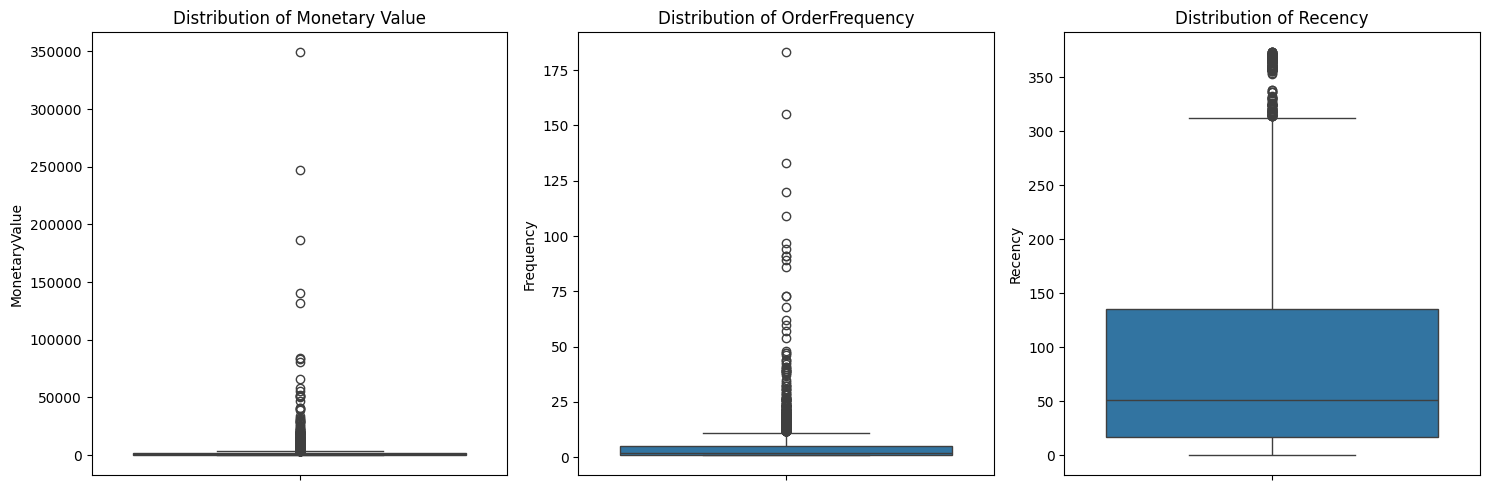

In [31]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(agg_data["MonetaryValue"])
plt.title("Distribution of Monetary Value")

plt.subplot(1,3,2)
sns.boxplot(agg_data["Frequency"])
plt.title("Distribution of OrderFrequency")

plt.subplot(1,3,3)
sns.boxplot(agg_data["Recency"])
plt.title("Distribution of Recency")


plt.tight_layout()
plt.show()

The data reveals the presence of outliers across all three fields—'MonetaryValue,' 'Frequency,' and 'Recency.' However, 'MonetaryValue' and 'Frequency' contain particularly extreme outliers.

These extreme values could reflect unique purchasing behaviors, such as a small number of high-value transactions or customers with exceptionally high order frequencies, which may skew the overall analysis. 

To gain clearer insights, further examination and possible treatment of these outliers is required to avoid potential distortions in data distribution.

#### Removing Outliers

In [32]:
# First we will remove potential outliers from the 'MonetaryValue' field

M_q1 = agg_data['MonetaryValue'].quantile(0.25)
M_q3 = agg_data['MonetaryValue'].quantile(0.75)
M_iqr = M_q3 - M_q1

m_mask = ((agg_data["MonetaryValue"]>(M_q3+1.5*M_iqr)) |
          (agg_data["MonetaryValue"]<(M_q1-1.5*M_iqr)))

In [33]:
# potential outliers for the 'Frequency' field

F_q1 = agg_data['Frequency'].quantile(0.25)
F_q3 = agg_data['Frequency'].quantile(0.75)
F_iqr = F_q3 - F_q1

f_mask = ((agg_data["Frequency"]>(F_q3+1.5*F_iqr)) |
          (agg_data["Frequency"]<(F_q1-1.5*F_iqr)))

In [34]:
cleaned_agg_data = agg_data[~(m_mask) & ~(f_mask)]
cleaned_agg_data.describe()

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency
count,3809.000000,3809.000000,3809.000000,3809,3809.000000
mean,15376.482804,885.502197,2.863481,2010-09-03 11:16:46.516146176,97.082174
min,12346.000000,1.550000,1.000000,2009-12-01 10:49:00,0.000000
25%,13912.000000,279.910000,1.000000,2010-07-08 14:48:00,22.000000
50%,15389.000000,588.050000,2.000000,2010-10-12 16:25:00,58.000000
75%,16854.000000,1269.050000,4.000000,2010-11-17 13:14:00,154.000000
max,18287.000000,3788.210000,11.000000,2010-12-09 20:01:00,373.000000
std,1693.199806,817.672283,2.243748,NaN,98.111495


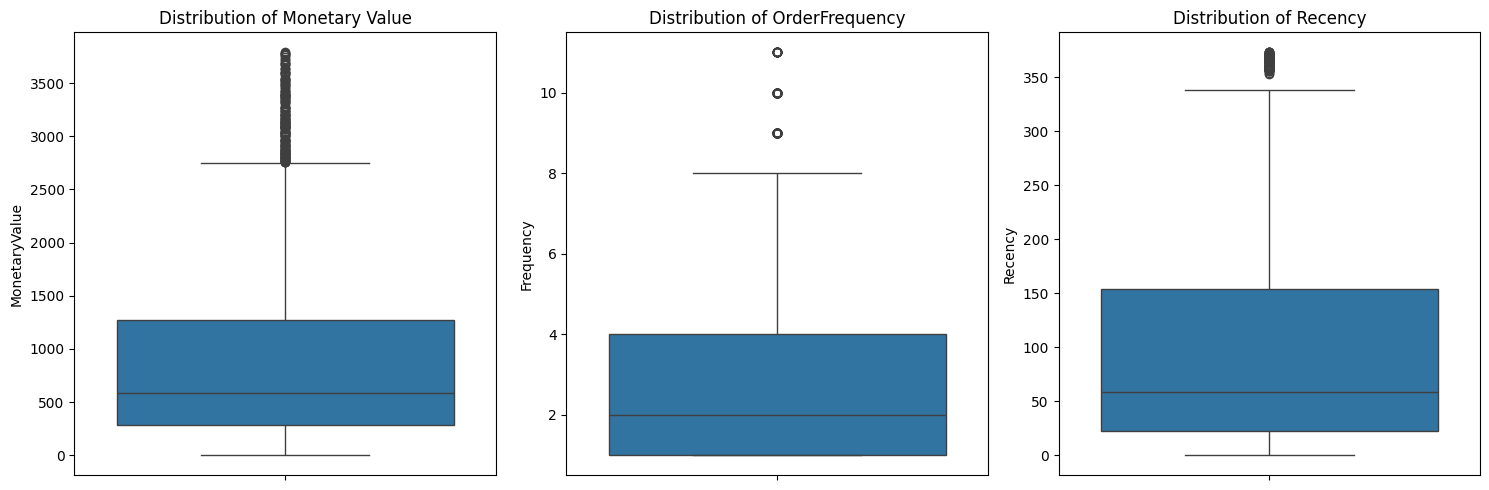

In [35]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(cleaned_agg_data["MonetaryValue"])
plt.title("Distribution of Monetary Value")

plt.subplot(1,3,2)
sns.boxplot(cleaned_agg_data["Frequency"])
plt.title("Distribution of OrderFrequency")

plt.subplot(1,3,3)
sns.boxplot(cleaned_agg_data["Recency"])
plt.title("Distribution of Recency")


plt.tight_layout()
plt.show()

>After treating outliers, the data distribution for 'MonetaryValue,' 'Frequency,' and 'Recency' shows a much more manageable spread, with fewer extreme values skewing the analysis. 

This refined distribution now has a more consistent range and reduced variability, making it suitable for clustering, as the clusters will likely be more meaningful and less impacted by outliers. We are ready to proceed with clustering.

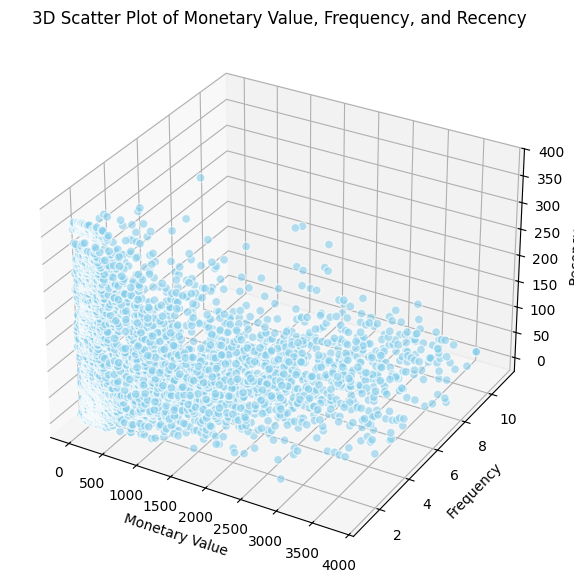

In [36]:
#3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cleaned_agg_data["MonetaryValue"], cleaned_agg_data["Frequency"], cleaned_agg_data["Recency"],
           color='skyblue', alpha=0.6, edgecolors='w', s=40)

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("3D Scatter Plot of Monetary Value, Frequency, and Recency")

plt.show()

#### Notes:
- All three fields have different scales, that could drastically impact clustering.

### Standard Scaling 

In [37]:
scaler = StandardScaler()

scaler.fit(cleaned_agg_data[["MonetaryValue", "Frequency", "Recency"]])

StandardScaler()

In [38]:
scaled_agg_data = cleaned_agg_data[["Customer ID","MonetaryValue", "Frequency", "Recency"]].copy()
scaled_agg_data[["MonetaryValue", "Frequency", "Recency"]] = scaler.transform(cleaned_agg_data[["MonetaryValue", "Frequency", "Recency"]])

In [39]:
scaled_agg_data

,Customer ID,MonetaryValue,Frequency,Recency
0,12346.0,-0.875945,-0.384889,0.682149
1,12347.0,0.535514,-0.384889,-0.969251
2,12348.0,-0.812586,-0.830631,-0.245489
3,12349.0,1.633678,-0.384889,-0.561498
4,12351.0,-0.715016,-0.830631,-0.887700
...,...,...,...,...
4280,18283.0,-0.298120,1.398076,-0.816344
4281,18284.0,-0.579553,-0.830631,-0.316846
4282,18285.0,-0.621972,-0.830631,2.017539
4283,18286.0,0.441467,-0.384889,0.141876


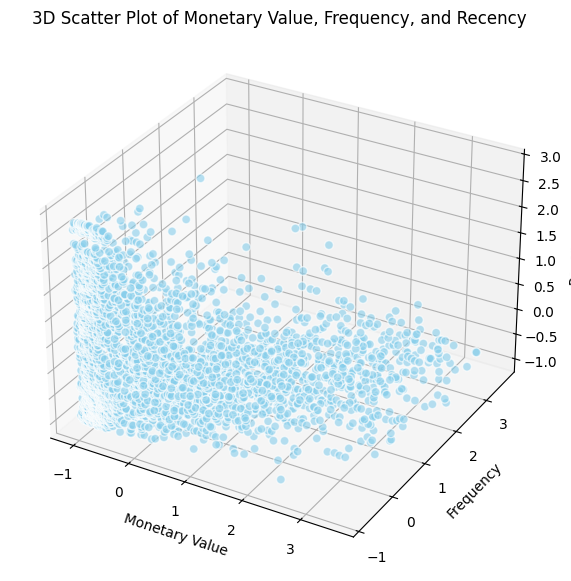

In [40]:
#3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(scaled_agg_data["MonetaryValue"], scaled_agg_data["Frequency"], scaled_agg_data["Recency"],
           color='skyblue', alpha=0.6, edgecolors='w', s=40)

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("3D Scatter Plot of Monetary Value, Frequency, and Recency")

plt.show()

# KMeans Clustering

In [41]:
df = scaled_agg_data[["MonetaryValue", "Frequency", "Recency"]]

#### Elbow Method

First we will use the elbow method to find the optimal number of clusters.

In [42]:
# Lists to hold SSE and silhouette score values
sse = []
silhouette_scores = []

# the range of k values
k_range = range(2, 13)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)
    
    score = silhouette_score(df, kmeans.labels_)
    silhouette_scores.append(score)

#### Elbow Curve & Silhouette Scores

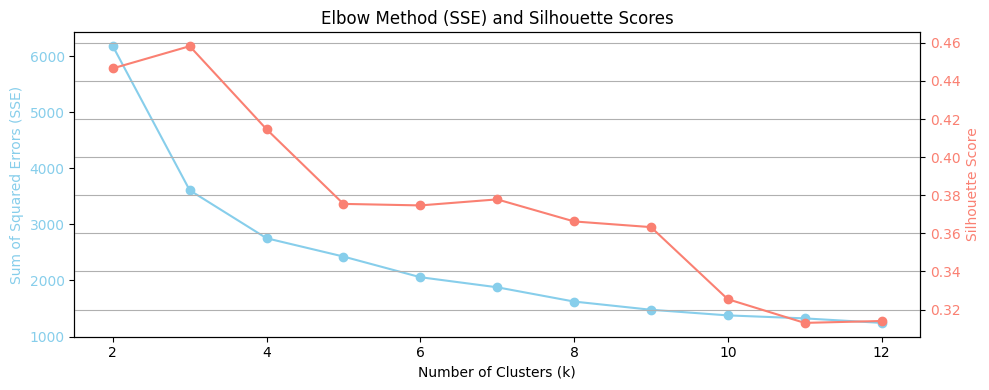

In [43]:
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plotting SSE
ax1.plot(k_range, sse, marker='o', color='skyblue', label='SSE')
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Sum of Squared Errors (SSE)", color="skyblue")
ax1.tick_params(axis='y', labelcolor="skyblue")
ax1.set_title("Elbow Method (SSE) and Silhouette Scores")

# Plotting silhouette score
ax2 = ax1.twinx()
ax2.plot(k_range, silhouette_scores, marker='o', color='salmon', label='Silhouette Score')
ax2.set_ylabel("Silhouette Score", color="salmon")
ax2.tick_params(axis='y', labelcolor="salmon")

fig.tight_layout()
plt.grid(True)
plt.show()

**Elbow Method**: 

There is a significant drop in SSE from 𝑘 = 2 to 𝑘 = 4, indicating that increasing clusters initially helps to reduce error. After 𝑘 = 4 and 𝑘 = 5, the decrease in SSE becomes more gradual, indicating diminishing returns. 

**Silhouette Score**: 

The silhouette score is highest at 𝑘 = 3 with 0.458 and a slight lower at 𝑘 = 4(which gives an optimal k using elbow method). The score decreases as 𝑘 increases beyond 3, suggesting that the cluster cohesion and separation worsen as we add more clusters.

**Optimal k**: 

Based on the elbow in SSE and the peak in the silhouette score, 𝑘=4 is likely the optimal number of clusters. This choice balances a SSE reductuon with the reasonable silhouette score.

### Clustering Model 

In [44]:
kmeans = KMeans(n_clusters=4, max_iter=1000, random_state=0)

kmeans.fit(df)

KMeans(max_iter=1000, n_clusters=4, random_state=0)

In [46]:
cleaned_agg_data['ClusterLabel'] = kmeans.predict(df)
cleaned_agg_data

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,ClusterLabel
0,12346.0,169.36,2,2010-06-28 13:53:00,164,0
1,12347.0,1323.32,2,2010-12-07 14:57:00,2,2
2,12348.0,221.16,1,2010-09-27 14:59:00,73,3
3,12349.0,2221.14,2,2010-10-28 08:23:00,42,2
4,12351.0,300.93,1,2010-11-29 15:23:00,10,3
...,...,...,...,...,...,...
4280,18283.0,641.77,6,2010-11-22 15:30:00,17,2
4281,18284.0,411.68,1,2010-10-04 11:33:00,66,3
4282,18285.0,377.00,1,2010-02-17 10:24:00,295,0
4283,18286.0,1246.43,2,2010-08-20 11:57:00,111,2


In [47]:
cleaned_agg_data['Cluster'] = cleaned_agg_data['ClusterLabel'].map(
    {
        0: "Blue",
        1: "Orange",
        2: "Green",
        3: "Red"
    }
)

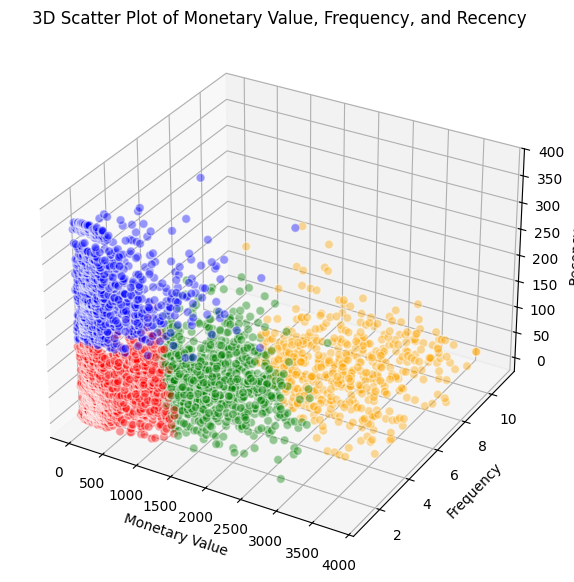

In [48]:
#3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cleaned_agg_data["MonetaryValue"], cleaned_agg_data["Frequency"], cleaned_agg_data["Recency"],
           c=cleaned_agg_data["Cluster"], alpha=0.4, edgecolors="w", s=40)

ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")
ax.set_title("3D Scatter Plot of Monetary Value, Frequency, and Recency")

plt.show()

This shows the four distinct groups of customers:
1. High Spenders with great frequency and low recency.
2. Low Spenders with low frequqncu and low recency.
3. Low Spenders but with high recency and average frequency.
4. Average Spenders, with average recency and average frequency.

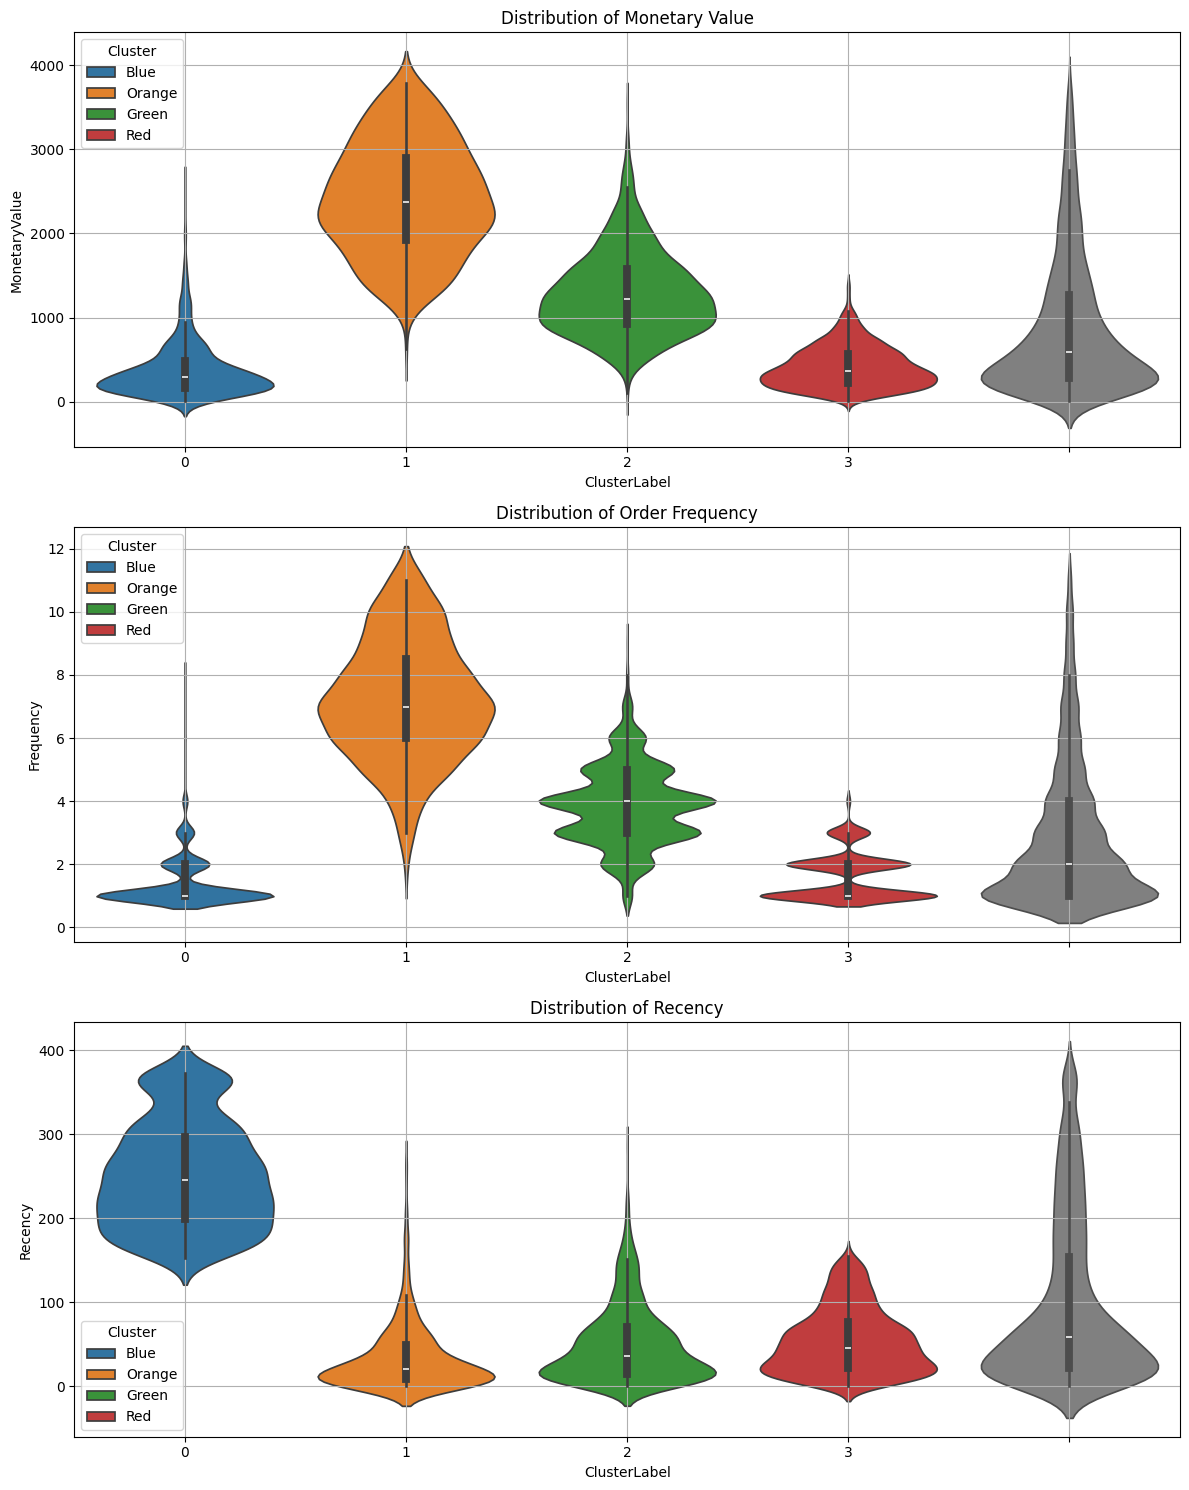

In [49]:
plt.figure(figsize=(12,15))

plt.subplot(3,1,1)
sns.violinplot(x=cleaned_agg_data["ClusterLabel"], y=cleaned_agg_data["MonetaryValue"], hue=cleaned_agg_data["Cluster"])
sns.violinplot(cleaned_agg_data["MonetaryValue"], color="gray")
plt.title("Distribution of Monetary Value")
plt.grid(True)

plt.subplot(3,1,2)
sns.violinplot(x=cleaned_agg_data["ClusterLabel"], y=cleaned_agg_data["Frequency"], hue=cleaned_agg_data["Cluster"])
sns.violinplot(cleaned_agg_data["Frequency"], color="gray")
plt.title("Distribution of Order Frequency")
plt.grid(True)

plt.subplot(3,1,3)
sns.violinplot(x=cleaned_agg_data["ClusterLabel"], y=cleaned_agg_data["Recency"], hue=cleaned_agg_data["Cluster"])
sns.violinplot(cleaned_agg_data["Recency"], color="gray")
plt.title("Distribution of Recency")
plt.grid(True)

plt.tight_layout()
plt.show()

Cluster 0 *Blue* has 
- low Monetary value than usual.
- low frequency than average frequency.
- high recency than normal.

Cluster 1 *Orange* has 
- high Monetary value.
- high frequency than average frequency.
- slight low recency.

Cluster 2 *Green* has 
- moderate Monetary value.
- higher than usual frequency.
- slight low recency.

Cluster 3 *Red* has 
- low Monetary value.
- lower than usual frequency.
- somewhat moderate recency.

Based on this we can conclude following:

#### Cluster 0 (Blue) - "Re-Engage"

**Rationale:** 

Customers in this cluster have low engagement, as indicated by their low frequency and high recency (long time since last purchase), and they generate relatively low revenue.

**Actions:**

- **Re-engagement Campaigns:** Implement targeted promotions or reminders to encourage these customers to return.
- **Loyalty Incentives:** Offer discounts or loyalty points to incentivize more frequent purchases.
- **Feedback Collection:** Send surveys to understand why these customers are less engaged and identify barriers to more frequent purchases.


#### Cluster 1 (Orange) - "Reward"

**Rationale:** 

This group shows high monetary value and frequency with a shorter recency, indicating strong loyalty and frequent purchases. These are likely the most valuable customers.


**Actions:**
- **VIP Treatment:** Offer exclusive benefits such as early access to new products, premium support, or loyalty rewards to strengthen their connection with the brand.
- **Retention Programs:** Provide personalized offers or recommendations based on past purchases to maintain high engagement.
- **Referral Programs:** Encourage these customers to refer others, leveraging their loyalty to expand your customer base.


#### Cluster 2 (Green) - "Retain"

**Rationale:** 

This group shows moderate engagement and spending but may need nurturing to prevent attrition. Their recent engagement indicates that they’re interested but not as frequent or high-value as Cluster 1.

**Actions:**
- **Upselling Opportunities:** Introduce product bundles or discounts on higher-value items to increase their purchase size.
- **Increased Engagement:** Consider targeted communications that showcase benefits of more frequent purchases to potentially move them toward higher engagement.
- **Personalized Recommendations:** Use data-driven insights to offer them products that align with their preferences, to encourage repeat purchases.
- **Incentivize Engagement:** Provide discounts or special offers to encourage them to buy again sooner rather than later.


#### Cluster 3 (Red) - "Nurture"

**Rationale:** 

These customers have low spending and infrequent purchases but have engaged recently, indicating a potential interest. They may not yet see the full value in the brand, making them ideal for nurturing strategies.

**Actions:**
- **Encourage Higher Engagement:** Provide smaller, introductory discounts or bundles to drive them toward higher purchase frequency and spending.
- **Highlight Brand Value:** Send targeted emails that showcase the value and uniqueness of the brand to increase their perceived value.
- **Follow-Up After Purchase:** Ensure that post-purchase support or personalized follow-ups enhance their experience and encourage them to buy again.

In [65]:
cleaned_agg_data['CustomerGroup'] = cleaned_agg_data['ClusterLabel'].map({
    0: "Re-Engage",
    1: "Reward",
    2: "Retain",
    3: "Nurture"
})

cleaned_agg_data = cleaned_agg_data.drop(columns=['Cluster'])

cleaned_agg_data

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,ClusterLabel,CustomerGroup
0,12346.0,169.36,2,2010-06-28 13:53:00,164,0,Re-Engage
1,12347.0,1323.32,2,2010-12-07 14:57:00,2,2,Retain
2,12348.0,221.16,1,2010-09-27 14:59:00,73,3,Nurture
3,12349.0,2221.14,2,2010-10-28 08:23:00,42,2,Retain
4,12351.0,300.93,1,2010-11-29 15:23:00,10,3,Nurture
...,...,...,...,...,...,...,...
4280,18283.0,641.77,6,2010-11-22 15:30:00,17,2,Retain
4281,18284.0,411.68,1,2010-10-04 11:33:00,66,3,Nurture
4282,18285.0,377.00,1,2010-02-17 10:24:00,295,0,Re-Engage
4283,18286.0,1246.43,2,2010-08-20 11:57:00,111,2,Retain


## Manual Clustering of Outlier Data

In [66]:
#monetary and frequency outliers data
monetary_outliers_df = agg_data[m_mask]
frequency_outliers_df = agg_data[f_mask]

#overlapping records between monetary and frequency outliers
overlapping_df = pd.merge(monetary_outliers_df, frequency_outliers_df, how='inner')

# only monetary outliers data
only_monetary_outliers_df = monetary_outliers_df[~monetary_outliers_df.index.isin(frequency_outliers_df.index)]

# only the frequency outliers data
only_frequency_outliers_df = frequency_outliers_df[~frequency_outliers_df.index.isin(monetary_outliers_df.index)]

In [67]:
## len(overlapping_df), len(only_monetary_outliers_df), len(only_frequency_outliers_df)

In [68]:
only_monetary_outliers_df["ClusterLabel"] = -1
only_frequency_outliers_df["ClusterLabel"] = -2
overlapping_df["ClusterLabel"] = -3

In [69]:
outliers_cluster_df = pd.concat([only_monetary_outliers_df, only_frequency_outliers_df, overlapping_df])
outliers_cluster_df

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,ClusterLabel
9,12357.0,11229.99,1,2010-11-16 10:05:00,23,-1
25,12380.0,4782.84,4,2010-08-31 14:54:00,100,-1
42,12409.0,12346.62,4,2010-10-15 10:24:00,55,-1
48,12415.0,19468.84,4,2010-11-29 15:07:00,10,-1
61,12431.0,4145.52,11,2010-12-01 10:03:00,8,-1
...,...,...,...,...,...,...
221,18223.0,7516.31,12,2010-11-17 12:20:00,22,-3
222,18225.0,7545.14,15,2010-12-09 15:46:00,0,-3
223,18226.0,6650.83,15,2010-11-26 15:51:00,13,-3
224,18231.0,4791.80,23,2010-10-29 14:17:00,41,-3


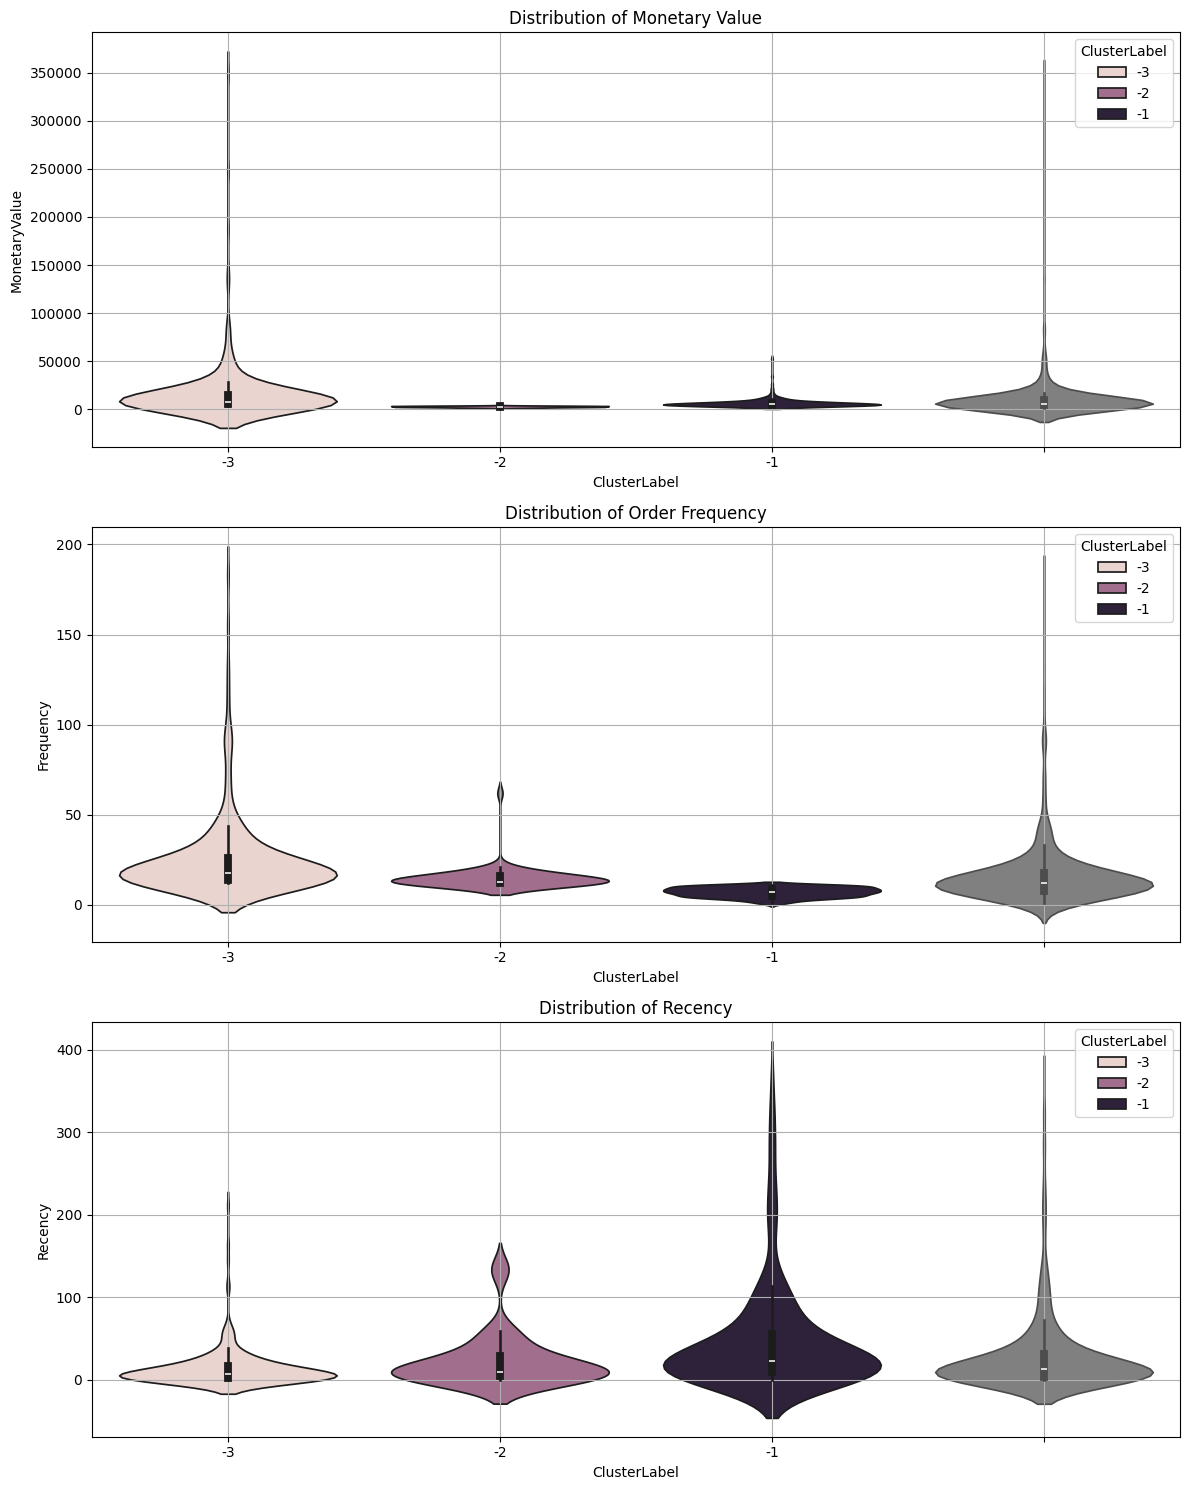

In [70]:
plt.figure(figsize=(12,15))

plt.subplot(3,1,1)
sns.violinplot(x=outliers_cluster_df["ClusterLabel"], y=outliers_cluster_df["MonetaryValue"], hue=outliers_cluster_df["ClusterLabel"])
sns.violinplot(outliers_cluster_df["MonetaryValue"], color="gray")
plt.title("Distribution of Monetary Value")
plt.grid(True)

plt.subplot(3,1,2)
sns.violinplot(x=outliers_cluster_df["ClusterLabel"], y=outliers_cluster_df["Frequency"], hue=outliers_cluster_df["ClusterLabel"])
sns.violinplot(outliers_cluster_df["Frequency"], color="gray")
plt.title("Distribution of Order Frequency")
plt.grid(True)

plt.subplot(3,1,3)
sns.violinplot(x=outliers_cluster_df["ClusterLabel"], y=outliers_cluster_df["Recency"], hue=outliers_cluster_df["ClusterLabel"])
sns.violinplot(outliers_cluster_df["Recency"], color="gray")
plt.title("Distribution of Recency")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Cluster -3: Super Premium Customers

**Rationale:** 

This cluster has very high monetary value and frequency compared to the normal data, along with a moderate recency score. They are characterized by substantial spending and a tendency to purchase frequently, indicating a strong level of engagement.

**Actions:**
- **Exclusive Offers:** Provide exclusive deals or early access to new products to reward these loyal customers and encourage them to continue purchasing.
- **Customer Appreciation:** Host events or send personalized thank-you notes to recognize their value and strengthen the relationship.
- **Upselling Opportunities:** Focus on upselling higher-end products or complementary items to further increase their average spend.


#### Cluster -2: Occasional Bargain Seekers

**Rationale:** 

This cluster has a low monetary value but a high frequency of purchases compared to the normal data, indicating that these customers are looking for deals and may be price-sensitive.

**Actions:**
- **Promotional Campaigns:** Launch campaigns focused on discounts and promotions to encourage these customers to make more frequent purchases.
- **Product Bundling:** Offer bundle deals to increase their average order value and provide a sense of value for their purchases.
- **Engagement Strategies:** Increase engagement through targeted emails or special events that highlight sales, ensuring they are aware of opportunities to buy.


#### Cluster -1: High-Value Infrequent Buyers

**Rationale:** 

This cluster exhibits a significantly higher monetary value and frequency than the normal data, indicating that these customers are starting to develop loyalty but may not yet be fully engaged. Their recency score suggests they have made recent purchases, showing potential for ongoing engagement.

**Actions:**
- **Loyalty Programs:** Implement a rewards program to encourage these customers to continue purchasing and further enhance their loyalty.
- **Personalized Marketing:** Use targeted communication that highlights new products and personalized recommendations based on their purchase history to increase their spending.
- **Feedback and Engagement:** Reach out for feedback to understand their needs better and build a stronger relationship with them.

In [71]:
outliers_cluster_df['CustomerGroup'] = outliers_cluster_df['ClusterLabel'].map({
    -1: "Encourage",
    -2: "Incentive",
    -3: "Premium"
})

In [72]:
clustered_data = pd.concat([cleaned_agg_data, outliers_cluster_df])
clustered_data

,Customer ID,MonetaryValue,Frequency,LastInvoiceDate,Recency,ClusterLabel,CustomerGroup
0,12346.0,169.36,2,2010-06-28 13:53:00,164,0,Re-Engage
1,12347.0,1323.32,2,2010-12-07 14:57:00,2,2,Retain
2,12348.0,221.16,1,2010-09-27 14:59:00,73,3,Nurture
3,12349.0,2221.14,2,2010-10-28 08:23:00,42,2,Retain
4,12351.0,300.93,1,2010-11-29 15:23:00,10,3,Nurture
...,...,...,...,...,...,...,...
221,18223.0,7516.31,12,2010-11-17 12:20:00,22,-3,Premium
222,18225.0,7545.14,15,2010-12-09 15:46:00,0,-3,Premium
223,18226.0,6650.83,15,2010-11-26 15:51:00,13,-3,Premium
224,18231.0,4791.80,23,2010-10-29 14:17:00,41,-3,Premium


# Clustering Result Analysis

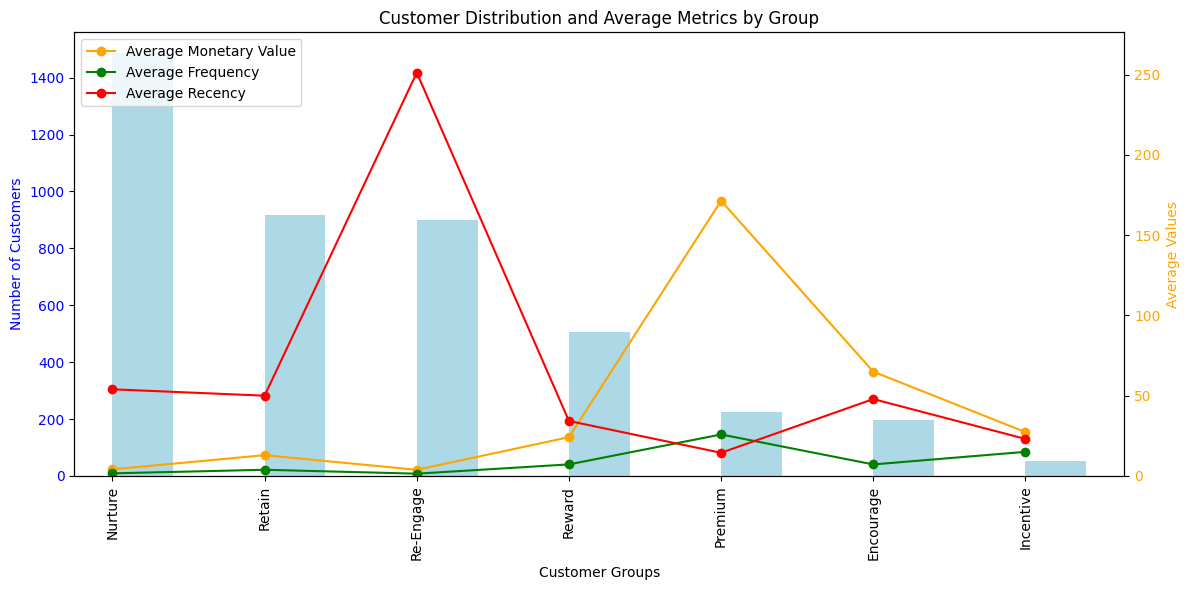

In [87]:
# the number of customers in each group
group_counts = clustered_data['CustomerGroup'].value_counts()

# average MonetaryValue, Frequency, and Recency for each group
clustered_data["Monetary Value per  £100"] = clustered_data['MonetaryValue']/100
group_averages = clustered_data.groupby('CustomerGroup').agg({
    'Monetary Value per  £100': 'mean',
    'Frequency': 'mean',
    'Recency': 'mean'
}).reset_index()

group_averages['CustomerGroup'] = pd.Categorical(
    group_averages['CustomerGroup'],
    categories=group_counts.index,
    ordered=True
)
group_averages = group_averages.sort_values('CustomerGroup').reset_index(drop=True)


fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for the number of customers
group_counts.plot(kind='bar', color='lightblue', ax=ax1, position=0, width=0.4, legend=False)
ax1.set_ylabel('Number of Customers', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Customer Groups')
ax1.set_title('Customer Distribution and Average Metrics by Group')

# secondary axis for average metrics
ax2 = ax1.twinx()
ax2.set_ylabel('Average Values', color='orange')

group_averages.plot(x='CustomerGroup', y='Monetary Value per  £100', ax=ax2, color='orange', marker='o', label='Average Monetary Value')
group_averages.plot(x='CustomerGroup', y='Frequency', ax=ax2, color='green', marker='o', label='Average Frequency')
group_averages.plot(x='CustomerGroup', y='Recency', ax=ax2, color='red', marker='o', label='Average Recency')

ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, max(group_averages[['Monetary Value per  £100', 'Frequency', 'Recency']].max()) * 1.1)  # Adjust Y-axis limit for better visibility

ax2.legend(loc='upper left')

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`The End`